### Case study of customer acquisition sources and marketing payback

Aim of the study: analyse costs and revenues of acquiring new customers by various acquisition sources and other cohorts, provide recommendations.

### Step 1. Obtaining data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
# load datasets
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

### Step 2. Data preprocessing

In [3]:
def data_preprocessing(df):
    """
    Method that lowers column names, prints first 5 rows of the dataset,
    general info and checks for the duplicates and omitted values
    """
    display(df.head())
    df.columns = df.columns.str.lower()
    print('Duplicates: ', df.duplicated().sum(), '\n')
    print('Null:\n', df.isna().sum(), '\n')
    print(df.info())

In [4]:
# check data basic info
data_preprocessing(visits)
data_preprocessing(orders)
data_preprocessing(costs)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Duplicates:  0 

Null:
 user id          0
region           0
device           0
channel          0
session start    0
session end      0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session start  309901 non-null  object
 5   session end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Duplicates:  0 

Null:
 user id     0
event dt    0
revenue     0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user id   40212 non-null  int64  
 1   event dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Duplicates:  0 

Null:
 dt         0
channel    0
costs      0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


In [5]:
# rename columns according to the required style
visits = visits.rename(columns={
    'user id': 'user_id',
    'session start': 'session_start',
    'session end': 'session_end',
})
orders = orders.rename(columns={
    'user id': 'user_id',
    'event dt': 'event_dt'
})
# continue data preprocession with lowering letters and
# checking for the non-obvious duplicates
costs['channel'] = costs['channel'].str.lower()
print(costs['channel'].unique(), '\n')
for i in ['region', 'device', 'channel']:
    visits[i] = visits[i].str.lower()
    print(i, '\n\n', visits[i].unique(), '\n\n')

['faceboom' 'mediatornado' 'rocketsuperads' 'tiptop' 'yrabbit'
 'adnonsense' 'leapbob' 'opplecreativemedia' 'wahoonetbanner'
 'lambdamediaads'] 

region 

 ['united states' 'uk' 'france' 'germany'] 


device 

 ['iphone' 'mac' 'android' 'pc'] 


channel 

 ['organic' 'tiptop' 'rocketsuperads' 'yrabbit' 'faceboom' 'mediatornado'
 'adnonsense' 'leapbob' 'wahoonetbanner' 'opplecreativemedia'
 'lambdamediaads'] 




In [6]:
# change dates into pandas datetime format
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Duplicates or omitted data were not revealed during the analysis, data types were corrected.

### Step 3. Defining methods for main metrics calculation and data visualization

Methods that calculate metrics:

- `get_profiles()` — creates user profiles,
- `group_by_dimensions()` — groups data by various dimensions,
- `get_retention()` — calculates Retention Rate,
- `get_conversion()` — calculates Conversion Rate,
- `get_ltv()` — calculates LTV and ROI.

Methods for data visualization:

- `filter_data()` — calculates moving average,
- `plot_retention()` — plots Retention Rate,
- `plot_conversion()` — plots Conversion Rate,
- `plot_ltv_roi` — plots LTV & ROI.

In [7]:
def get_profiles(sessions, orders, ad_costs):
    """
    This method creates user profiles including first login date,
    acquisition channel, device and user region
    """
    
    # for further cohort analysis find parameters of the first login
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # add first login dates and months
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # add payer parameter (whether users made at least a single purchase)
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # count the number of unique users with the same source and date of acquisition
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # combine advertising costs and the acquired users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # divide advertising costs by the number of acquired users
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add acquisition costs to user profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # fill the cost of organic user acquisition with zeros
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [8]:
def group_by_dimensions(df, dims, horizon_days, cumsum=True, conv_ret=True):
    """
    This is support method that groups data by various dimensions (user cohorts)
    """
    # add conditions of data group (user count for conversion/retention,
    # revenue for LTV/ROI)
    if conv_ret:
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
    else:
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
    # add condition of data cumulation to calculate the conversion and LTV metrics
    if cumsum:
        result = result.fillna(0).cumsum(axis = 1)
    # calculate cohort size
    cohort_sizes = (
        df.groupby(dims)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    # combine cohort sizes and revenue table
    result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
    # calculate LTV: divide each “cell” in the row by the size of the cohort
    result = result.div(result['cohort_size'], axis=0)
    # exclude all lifetimes that exceed the analysis horizon
    result = result[['cohort_size'] + list(range(horizon_days))]
    # restore cohort sizes
    result['cohort_size'] = cohort_sizes
    # return result for the retention and conversion rates calculation
    # or continue calculation for the LTV, ROI and CAC metrics
    if conv_ret:
        return result
    else:
        # assemble dataframe with user data and CAC values by adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        # calculate average CAC using parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        # calculate ROI: devide LTV by CAC
        roi = result.div(cac['cac'], axis=0)
        # delete rows with endless ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        # restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes
        # add CAC in the ROI
        roi['cac'] = cac['cac']
        # in the resulting table, leave the cohort sizes, CAC and ROI in lifetimes
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        # return LTV and ROI
        return result, roi

In [9]:
def get_retention(
    profiles,  # user profiles DataFrame
    sessions,  # user sessions DataFrame
    observation_date,  # analysis observation date
    horizon_days,  # time horizon for analysis
    dimensions=[],  # dimensions for grouping results
    ignore_horizon=False,  # whether to ignore time horizon or not
):
    """
    This method calculates user retention
    """
    # add the "payer" column to the list of passed dimensions
    dimensions = ['payer'] + dimensions

    # exclude users who have not "survived" until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # gather "raw" data for retention calculation
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # get the retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days, cumsum=False)

    # get the retention dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days, cumsum=False
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [10]:
def get_conversion(
    profiles,  # user profiles DataFrame
    purchases,  # user purchases DataFrame
    observation_date,  # analysis observation date
    horizon_days,  # time horizon for analysis
    dimensions=[],  # dimensions for grouping results
    ignore_horizon=False,  # whether to ignore time horizon or not
):
    """
    This method calculates user conversion
    """
    # exclude users who have not "survived" until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # remove 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions: 
        dimensions = []

    # get the conversion dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time


In [11]:
def get_ltv(
    profiles,  # user profiles DataFrame
    purchases,  # user purchases DataFrame
    observation_date,  # analysis observation date
    horizon_days,  # time horizon for analysis
    dimensions=[],  # dimensions for grouping results
    ignore_horizon=False,  # whether to ignore time horizon or not
):
    """
    This method calculates user LTV, ROI and CAC
    """
    # exclude users who have not "survived" until the end of the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # add purchase data to user profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    # calculate user lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # group by cohort if there are no dimensions specified
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    # get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days, conv_ret=False
    )
    
    # remove 'cohort' from dimensions for dynamic tables
    if 'cohort' in dimensions:
        dimensions = []
    
    # get dynamic LTV and ROI tables
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days, conv_ret=False
    )
    
    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # dynamic LTV table
        roi_grouped,  # ROI table
        roi_in_time,  # dynamic ROI table
    )


In [12]:
def filter_data(df, window):
    """
    This method "smoothes" data, calculates moving average
    """
    # apply moving average to each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [13]:
def plot_retention(retention, retention_history, horizon, window=7):
    """
    This method plots user retention
    """
    # Set the grid size for the plots
    plt.figure(figsize=(15, 10))

    # Exclude cohort sizes and retention of the first day
    retention = retention.drop(columns=['cohort_size', 0])
    # In the retention history table, keep only the required lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # If the retention index only contains payers, add cohort as a second feature
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # Create a plot with two rows and two columns
    # In the first plot, plot the retention curves of paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # In the second plot, plot the retention curves of non-paying users
    # The vertical axis is shared with the first plot
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # In the third plot, plot the dynamics of paying user retention
    ax3 = plt.subplot(2, 2, 3)
    # Get the column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # Filter the data and plot the graph
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamics of retention of paying users on the {}-th day'.format(
            horizon
        )
    )

    # In the fourth plot, plot the dynamics of non-paying user retention
    # The vertical axis is shared with the third plot
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # Filter the data and plot the graph
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamics of retention of non-paying users on the {}-th day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    """
    This method plots user conversion
    """
    # set the size of the plot grid
    plt.figure(figsize=(15, 5))

    # drop the cohort size column from the conversion table
    conversion = conversion.drop(columns=['cohort_size'])
    # keep only the necessary lifetime in the conversion history table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first plot — conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    # second plot — conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # columns of the pivot table will be all index columns except date
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User conversion dynamics on the {}-th day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    """
    This method plots LTV, ROI and CAC
    """
    # Set plotting grid
    plt.figure(figsize=(20, 10))

    # Exclude cohort sizes from ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # Keep only required lifetime from ltv history table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # Record acquisition cost in a separate DataFrame
    cac_history = roi_history[['cac']]

    # Exclude cohort sizes and cac from roi table
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # Keep only required lifetime from roi history table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # First plot - LTV curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # Second plot - LTV dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # Pivot table by date and selected lifetime
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    # Apply moving average filter
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('LTV dynamics of users on day {}'.format(horizon))

    # Third plot - CAC dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # Pivot table by date
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    # Apply moving average filter
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('Acquisition cost dynamics')

    # Fourth plot - ROI curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Break-even level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # Fifth plot - ROI dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # Pivot table by date and selected lifetime
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    # Apply moving average filter
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Break-even level')
    plt.xlabel('Acquisition date')
    plt.title('ROI dynamics of users on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

### Step 4. Exploratory data analysis

In [16]:
# create user profiles using get_profiles method
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769


In [17]:
print('Minimum acquisition date: {0}'.format(profiles['dt'].min()))
'Maximum acquisition date: {0}'.format(profiles['dt'].max())

Minimum acquisition date: 2019-05-01


'Maximum acquisition date: 2019-10-27'

Customers were acquired between the following dates: 2019-05-01 and 2019-10-27.

In [18]:
def profiles_groups(profiles, column):
    """
    This method aggregates function to enhance tables construction
    """
    profiles_column = profiles.groupby(column).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
    profiles_payer = profiles.query('payer == True').groupby(column)['user_id'].nunique().sort_values(ascending=False)
    profiles_column = profiles_column.merge(profiles_payer, on=column, suffixes=('_total','_payer')).reset_index()
    profiles_column['payer_fraction_%'] = round(profiles_column['user_id_payer'] / profiles_column['user_id_total'] * 100, 2)
    profiles_column['total_fraction_%'] = round(profiles_column['user_id_total'] / profiles_column['user_id_total'].sum() * 100, 2)
    return profiles_column

In [19]:
# group users by regions
profiles_country = profiles_groups(profiles, 'region')
profiles_country

,region,user_id_total,user_id_payer,payer_fraction_%,total_fraction_%
0,united states,100002,6902,6.90,66.66
1,uk,17575,700,3.98,11.72
2,france,17450,663,3.80,11.63
3,germany,14981,616,4.11,9.99


Vast majority, over 66% of the acquired customers come from the United States. The USA leads in both cohorts of clients that made their first purchase and those who didn't. The fraction of payers among total number of clients varies by countries from 3.8% to 6.9% with France showing the smallest percentage.

In [20]:
# group users by device
profiles_device = profiles_groups(profiles, 'device')
profiles_device

,device,user_id_total,user_id_payer,payer_fraction_%,total_fraction_%
0,iphone,54479,3382,6.21,36.32
1,android,35032,2050,5.85,23.35
2,pc,30455,1537,5.05,20.30
3,mac,30042,1912,6.36,20.03


iPhone device accounts for over a third of all users activity. Moreover, customers with Apple devices, such as iPhones and Macs have the highest conversion rate as well - 6.21% and 6.36% respectively. Hence, this cohort is the most solvent.

In [21]:
# group users by acquisition channel
profiles_channel = profiles_groups(profiles, 'channel')
profiles_channel

,channel,user_id_total,user_id_payer,payer_fraction_%,total_fraction_%
0,organic,56439,1160,2.06,37.62
1,faceboom,29144,3557,12.20,19.43
2,tiptop,19561,1878,9.60,13.04
3,opplecreativemedia,8605,233,2.71,5.74
4,leapbob,8553,262,3.06,5.70
5,wahoonetbanner,8553,453,5.30,5.70
6,rocketsuperads,4448,352,7.91,2.97
7,mediatornado,4364,156,3.57,2.91
8,yrabbit,4312,165,3.83,2.87
9,adnonsense,3880,440,11.34,2.59


Most of the users were obtained without marketing campaigns. Such 'organic' users account for 37.62% of all unique user sessions. However, this user cohort monetizes poorly and makes up only about 2% of 'organic' payers.
Best customers with conversion rates above 10% were acquired via the following channels:
- faceboom;
- adnonsense;
- lambdamediaads.

### Step 5. Marketing source research

In [22]:
'Total amount of marketing expenses: {0}'.format(profiles['acquisition_cost'].sum().round().astype(int))

'Total amount of marketing expenses: 105497'

In [23]:
# calculate user acquisition cost by channel
marketing_by_source = profiles \
.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum') \
.sort_values(by='acquisition_cost', ascending=False) \
.reset_index()

marketing_by_source['total_fraction_%'] = round(marketing_by_source['acquisition_cost'] /
                                                marketing_by_source['acquisition_cost'].sum() * 100, 2)
marketing_by_source

,channel,acquisition_cost,total_fraction_%
0,tiptop,54751.30,51.90
1,faceboom,32445.60,30.75
2,wahoonetbanner,5151.00,4.88
3,adnonsense,3911.25,3.71
4,opplecreativemedia,2151.25,2.04
5,rocketsuperads,1833.00,1.74
6,leapbob,1797.60,1.70
7,lambdamediaads,1557.60,1.48
8,mediatornado,954.48,0.90
9,yrabbit,944.22,0.90


The most expensive acquisition channels are Tiptop and Faceboom. The channels account for around 52% and 31% of total marketing costs of the observed period respectively. Although it should be highlighted that Tiptop, being the most expensive marketing source, does not show best customer attraction results and provides only 9.6% of payer audience conversion (see details above). Whereas significantly cheaper marketing sources Adnonsense and Lambdamediaads that consumed in total 5.19% of overall marketing finances brought more qualitative users with conversion rates 11.34% and 10.47% respectively.

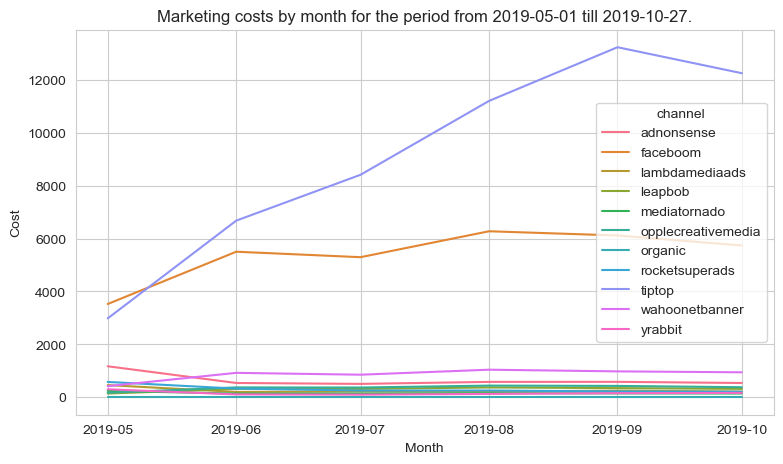

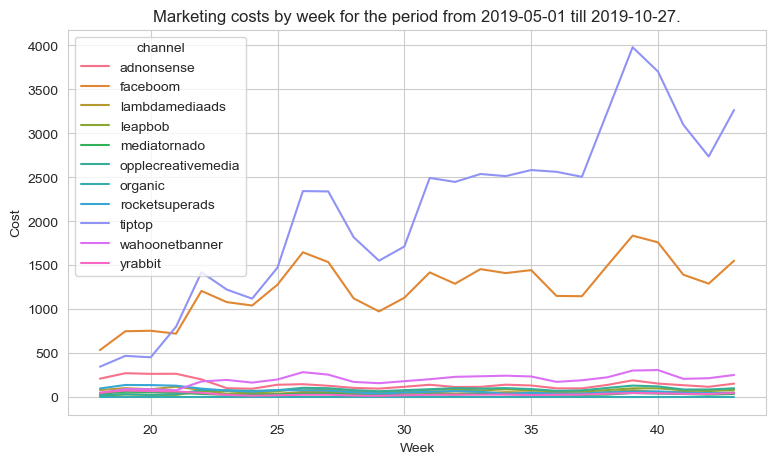

In [24]:
# add week number
profiles['week'] = profiles['first_ts'].dt.isocalendar().week

# plot marketing costs by month
costs_by_month = profiles.groupby(['month', 'channel'], as_index=False).agg({'acquisition_cost':'sum'})
plt.figure(figsize=(9, 5))
sns.set_style('whitegrid')
sns.lineplot(data=costs_by_month, x='month', y='acquisition_cost', hue='channel')
plt.title('Marketing costs by month for the period from 2019-05-01 till 2019-10-27.')
plt.xlabel('Month')
plt.ylabel('Cost')
plt.show()

# plot marketing costs by week
costs_by_week = profiles.groupby(['week', 'channel'], as_index=False).agg({'acquisition_cost':'sum'})
plt.figure(figsize=(9, 5))
sns.lineplot(data=costs_by_week, x='week', y='acquisition_cost', hue='channel')
plt.title('Marketing costs by week for the period from 2019-05-01 till 2019-10-27.')
plt.xlabel('Week')
plt.ylabel('Cost')
plt.show()

Faceboom and TipTop sources constitute more than 80% of the marketing expenses incurred from May until October 2019. Judjing by the figures above, marketing expenses on Tiptop  exceeded Faceboom's in May 2019 and continued sharp growth until September. Weekly graph shows similar pattern, where Tiptop's expenditures significantly exceed Faceboom's after 25-th week of 2019.

In [25]:
# average acquisition cost by channel
profiles \
.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean') \
.sort_values(by='acquisition_cost', ascending=False) \
.reset_index() \
.round(2)

,channel,acquisition_cost
0,tiptop,2.80
1,faceboom,1.11
2,adnonsense,1.01
3,lambdamediaads,0.72
4,wahoonetbanner,0.60
5,rocketsuperads,0.41
6,opplecreativemedia,0.25
7,yrabbit,0.22
8,mediatornado,0.22
9,leapbob,0.21


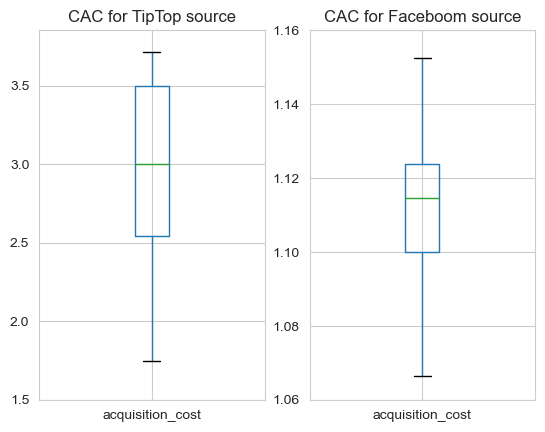

In [26]:
# boxplot CAC for TipTop and Faceboom sources
profiles[(profiles['channel'] == 'tiptop')][['channel', 'acquisition_cost']] \
.boxplot(grid=True, ax=plt.subplot(1,2,1))
plt.ylim(1.5)
plt.title('CAC for TipTop source')
profiles[(profiles['channel'] == 'faceboom')][['channel', 'acquisition_cost']] \
.boxplot(grid=True, ax=plt.subplot(1,2,2))
plt.title('CAC for Faceboom source')
plt.ylim(1.06, 1.16)
plt.show()

Information above shows the highest customer acquisition cost (CAC) for the TipTop channel with the 2.8 mean and the median of 3 units per user as well as 1-st and 3-d quantiles between roughly 2.5 and 3.5 units per user. These figures are twice higher comparing to the second expensive acquisition source - Faceboom with the median of 1.11 units and upper interquartile range border around 1.15 units.

### Step 6. Analysis of LTV, ROI, CAC Conversion and Retention metrics

In [27]:
horizon = 14 # set horizon period of 14 days
observation_date = datetime(2019, 11, 1).date()
profiles_filtered = profiles.query('channel != "organic"')
# use get_ltv method to calculate LTV, ROI and CAC
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_filtered, orders, observation_date, horizon)

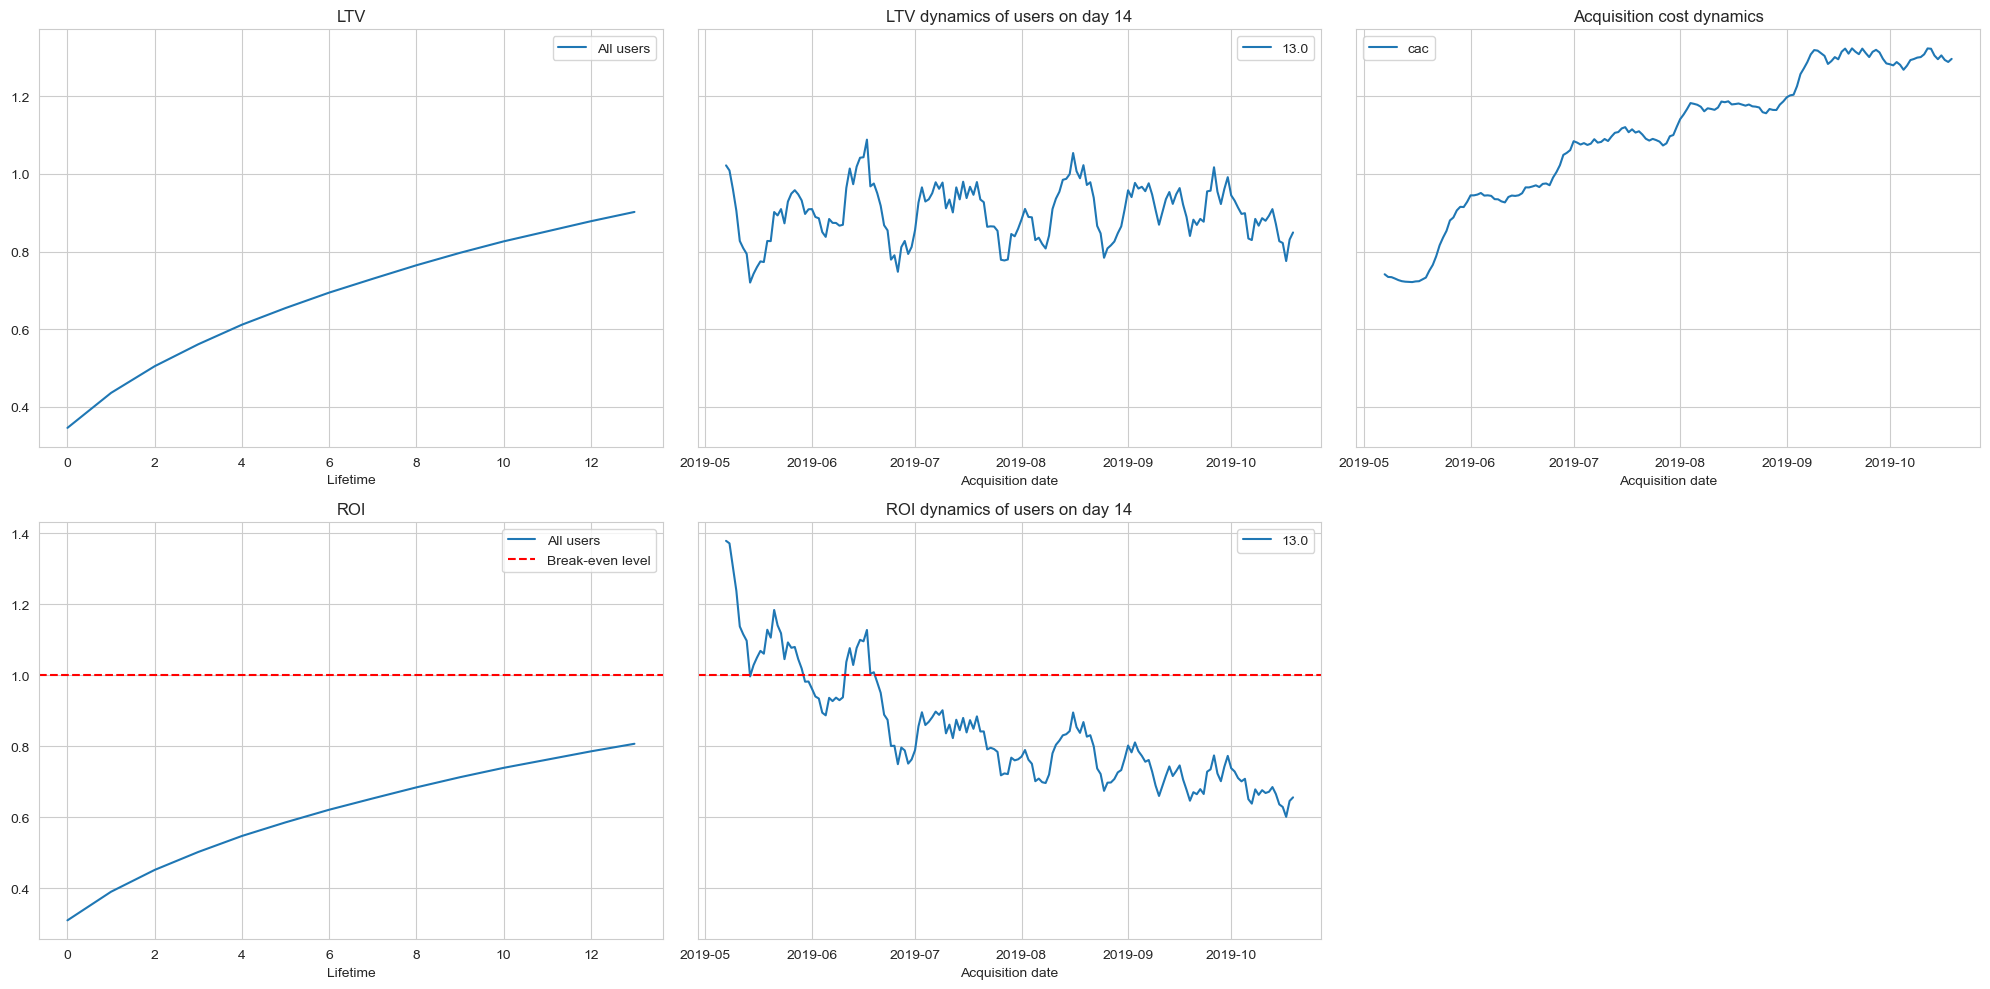

In [28]:
# use plot_ltv_roi method to plot LTV, ROI and CAC
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

Judging by the figures above, the overall marketing campaign was not efficient. ROI doesn't reach the payback level and CAC increases sharply in June 2019. This CAC increase correlates with the rise of marketing costs of the TipTop source for the same time period (see above). With the rise of CAC the dynamic of the 14-th day ROI shows dramatic decrease in June 2019 and breaking below the payback level in July 2019.
LTV dynamics on the 14-th lifetime day fluctuates stably showing not much difference among the acquired users monthly cohorts.

In [29]:
# use get_retention method to calculate retention
retention_raw, retention, retention_history = get_retention(profiles_filtered, visits, observation_date, horizon)
# use get_conversion method to calculate conversion
conversion_raw, conversion, conversion_history = get_conversion(profiles_filtered, orders, observation_date, horizon)

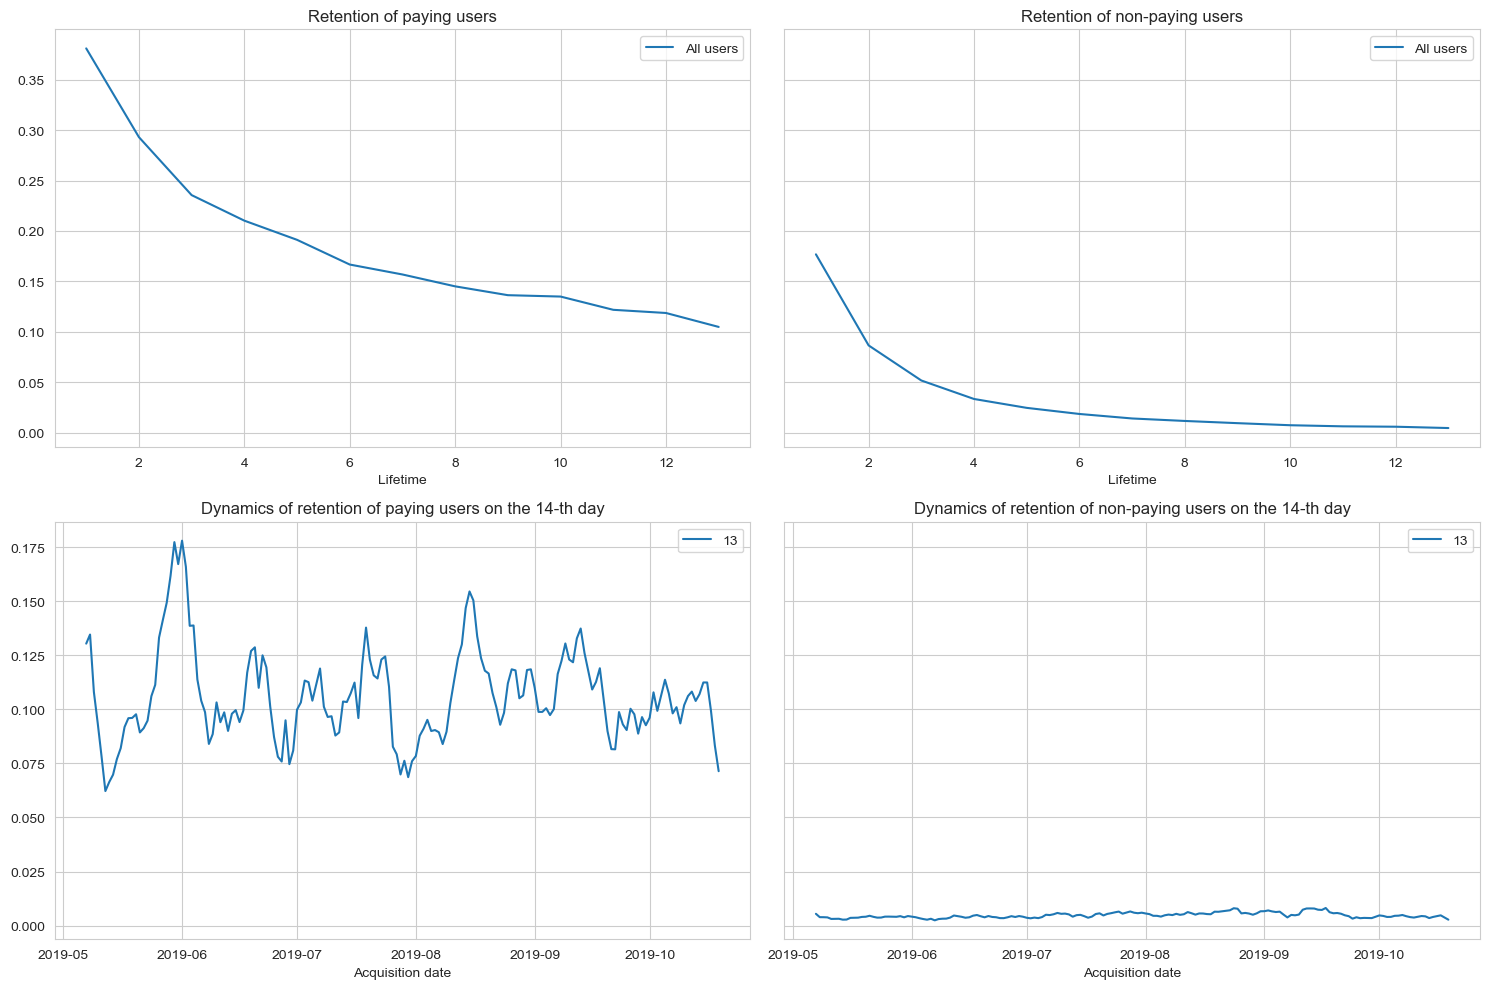

In [30]:
# use plot_retention method to plot retention
plot_retention(retention, retention_history, horizon)

Retention plots show regular customers behaviour with significant drop in retention levels for non-payer users as well as stable decline of retention with time. The retention dynamics on the 14-th lifetime day is mostly stable among all monthly cohorts.

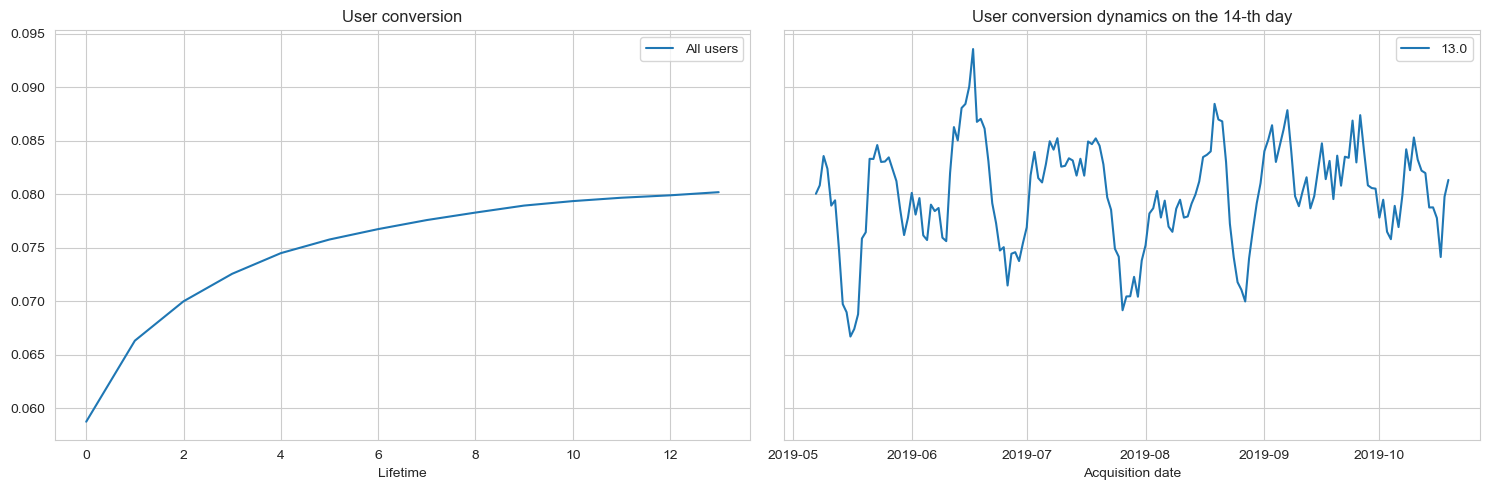

In [31]:
# use plot_conversion method to plot conversion
plot_conversion(conversion, conversion_history, horizon)

On the contrary, conversion rate's 14-th day dynamics represents that users acquired in June 2019 convert into buyers in higher volumes comparing to other user monthly cohorts (conversion rate peaks in the interval between 0.065 and 0.07, an all time high values).

In [32]:
# use get_ltv to calculate LTV, ROI and CAC by the dimension "device"
ltv_raw_device, ltv_device, ltv_history_device, roi_device, roi_history_device = get_ltv(
    profiles_filtered, orders, observation_date, horizon, dimensions=['device']
)

# use get_ltv to calculate LTV, ROI and CAC by the dimension "region"
ltv_raw_region, ltv_region, ltv_history_region, roi_region, roi_history_region = get_ltv(
    profiles_filtered, orders, observation_date, horizon, dimensions=['region']
)

# use get_ltv to calculate LTV, ROI and CAC by the dimension "channel"
ltv_raw_channel, ltv_channel, ltv_history_channel, roi_channel, roi_history_channel = get_ltv(
    profiles_filtered, orders, observation_date, horizon, dimensions=['channel']
)

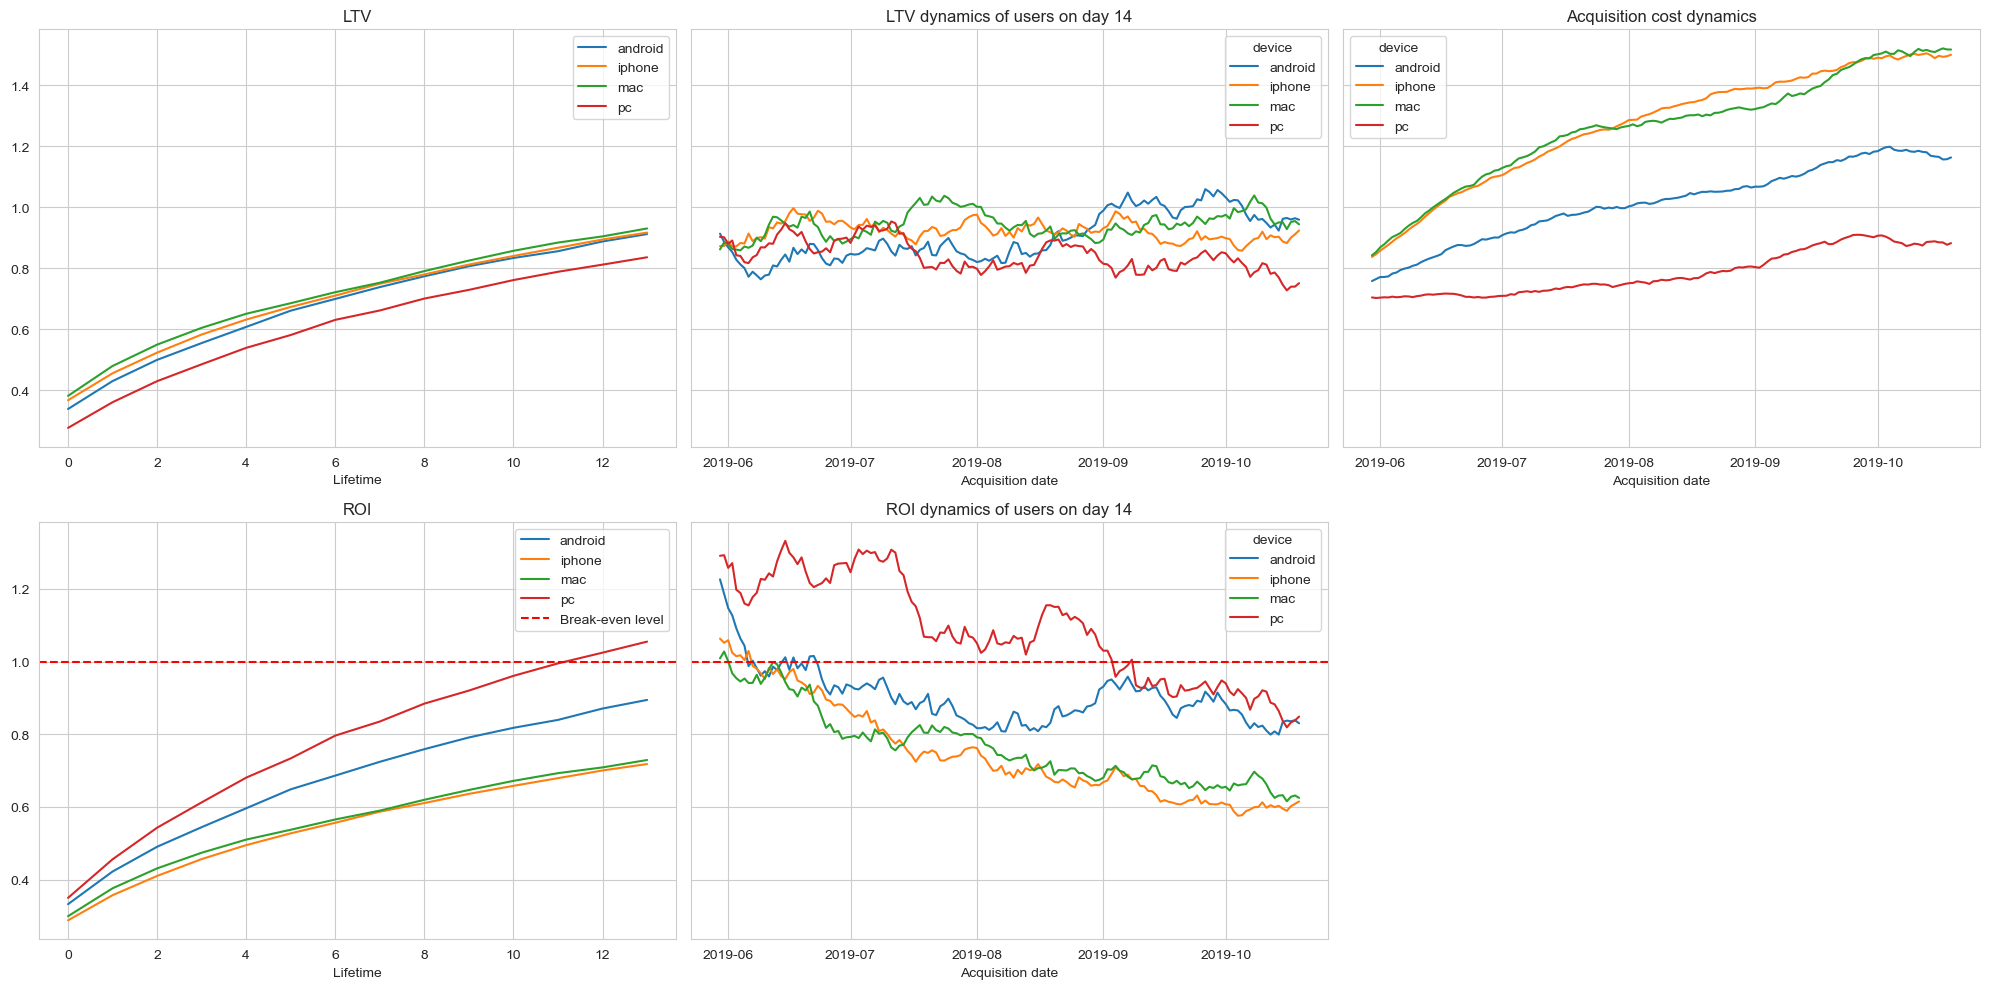

In [33]:
# use plot_ltv_roi method to plot LTV, ROI and CAC by various devices
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon, window=30)

PC platform shows lowest lifetime value of its users, although the costs of acquiring PC customers is the smallest as well, thus making PC cohort the most profitable and reaching PC payback level on the 7-th day of the lifetime. Moreover, PC is the only cohort that never falls below the payback level on the 14-th day lifetime no matter when the users are acquired.
Apart from PC, ROI payback level reaches Android cohort, though with much more modest ROI results (break even for Android users is reached around 11-th day of the lifetime). 
ROI of Mac and iPhone cohorts doesn't reach break even point for the whole 14 day lifetime period.

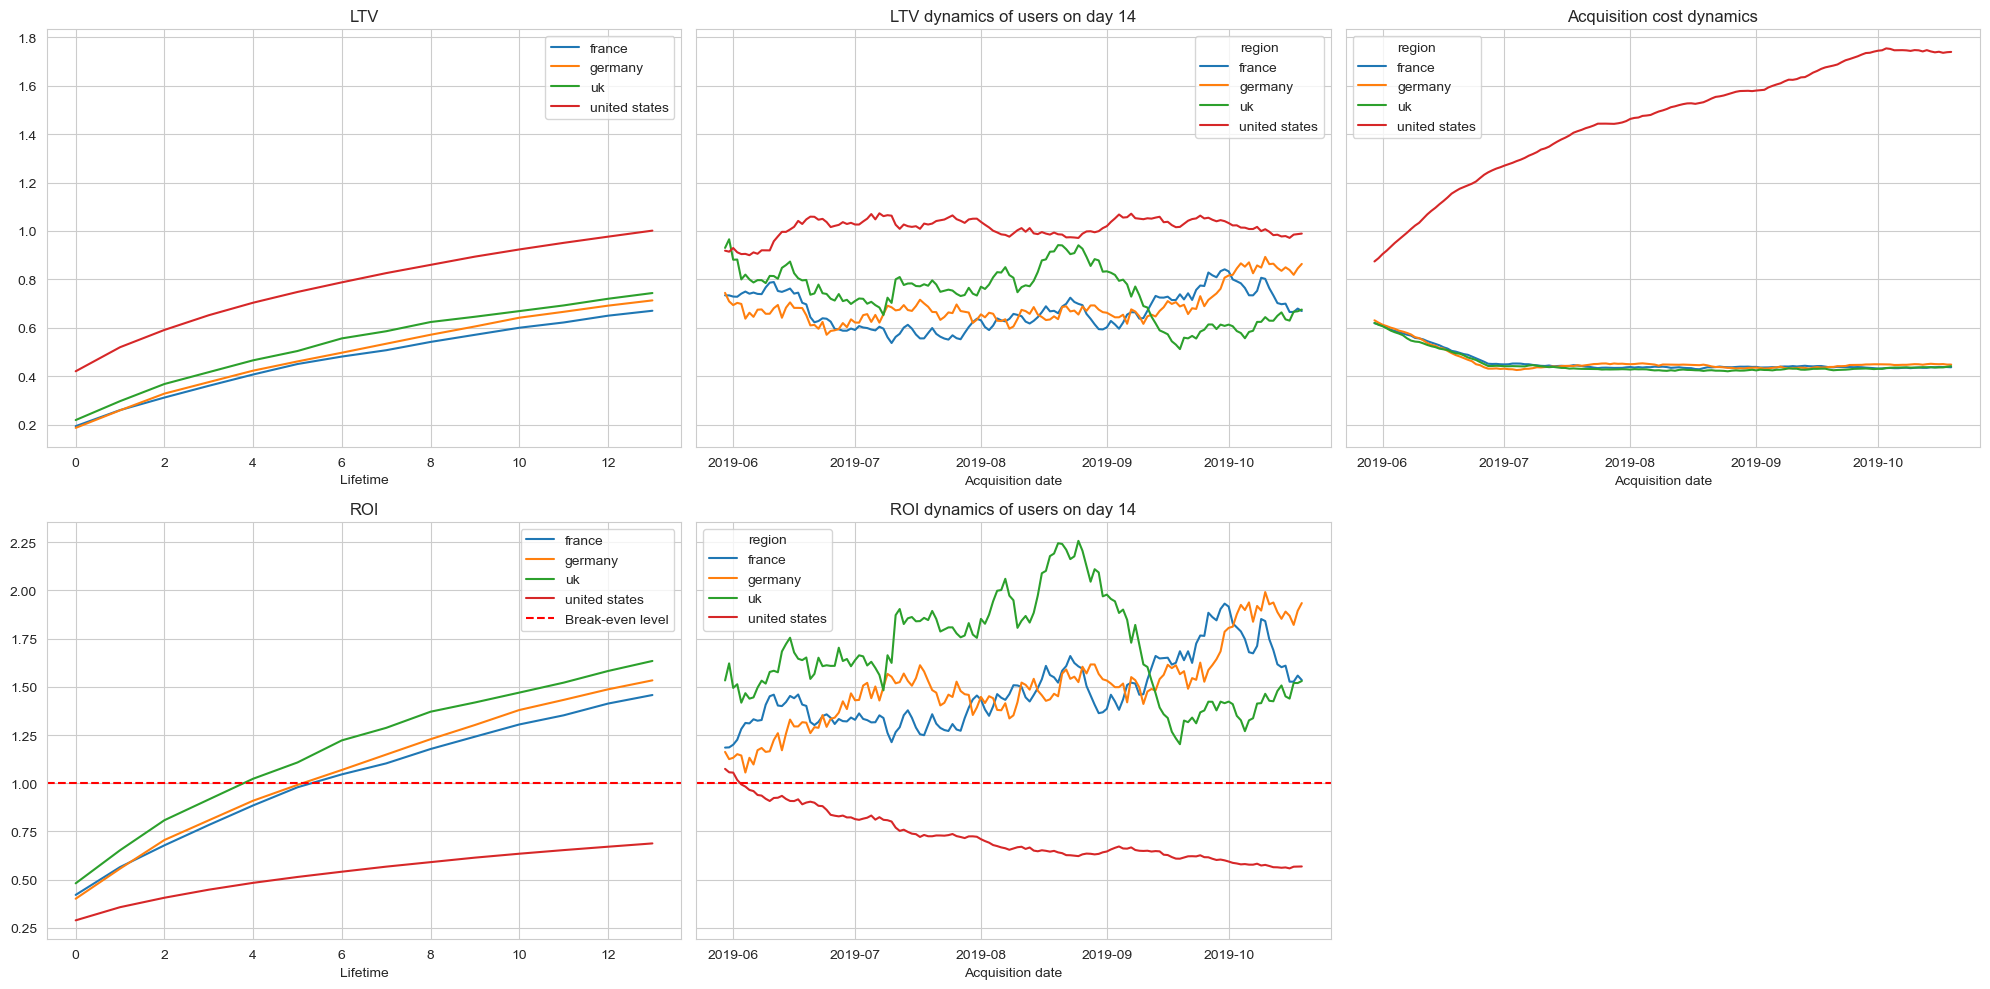

In [34]:
# use plot_ltv_roi method to plot LTV, ROI and CAC by various regions
plot_ltv_roi(ltv_region, ltv_history_region, roi_region, roi_history_region, horizon, window=30)

Despite the fact that, the US users brought the largest revenues for the company with LTV above 0.6, American cohort is the only one unprofitable with ROI below 1. The US 30 day moving average CAC rises sharply in June-July 2019, whereas for users from other countries marketing costs remain stable.

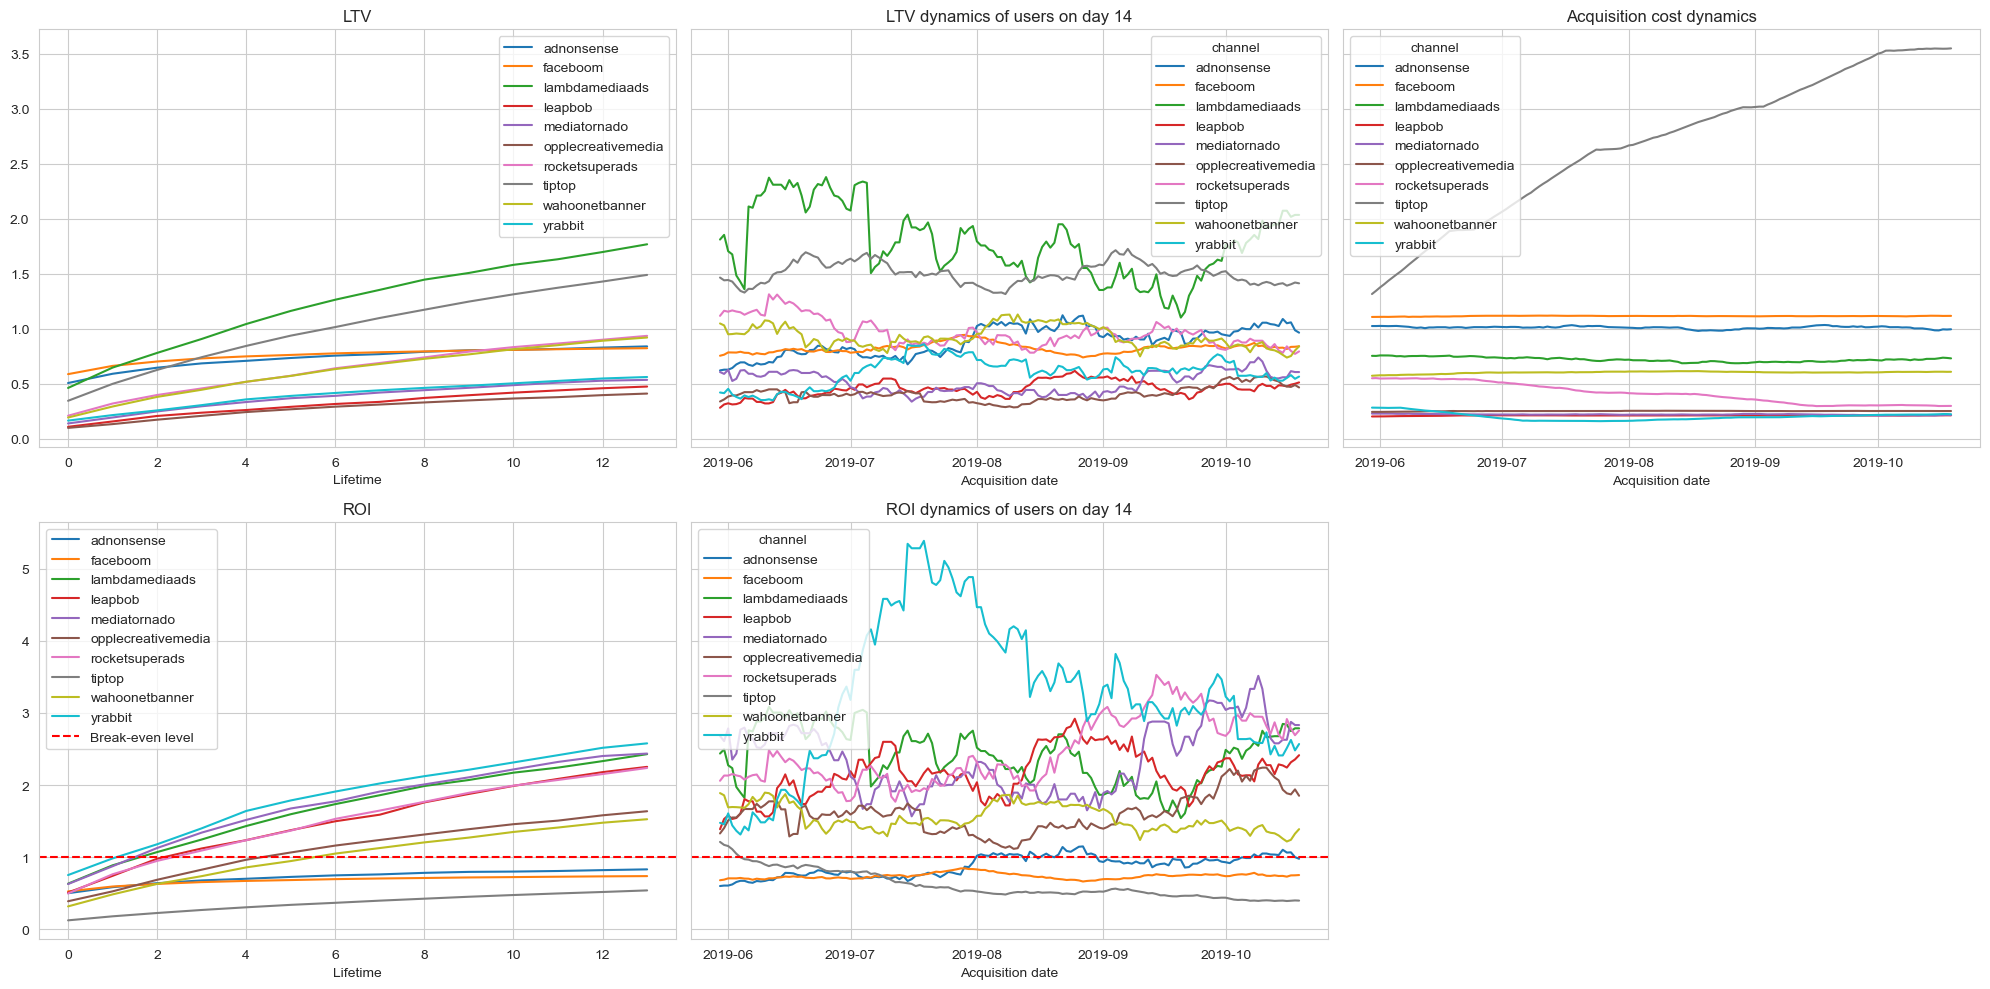

In [35]:
# use plot_ltv_roi method to plot LTV, ROI and CAC by various user acquisition sources
plot_ltv_roi(ltv_channel, ltv_history_channel, roi_channel, roi_history_channel, horizon, window=30)

Judging by the information above, TipTop, Faceboom and Adnonsense marketing channels are ineffective and have ROI below payback level. Moreover, TipTop's customer acquisition cost increases vastly during the period and by October 2019 becomes 3.5 time larger comparing to other sources.

In [36]:
# use get_retention method to calculate retention by various user acquisition sources
retention_raw_channel, retention_channel, retention_history_channel = get_retention(
    profiles_filtered, visits, observation_date, horizon, dimensions=['channel']
)
# use get_conversion method to calculate conversion by various user acquisition sources
conversion_raw_channel, conversion_channel, conversion_history_channel = get_conversion(
    profiles_filtered, orders, observation_date, horizon, dimensions=['channel']
)

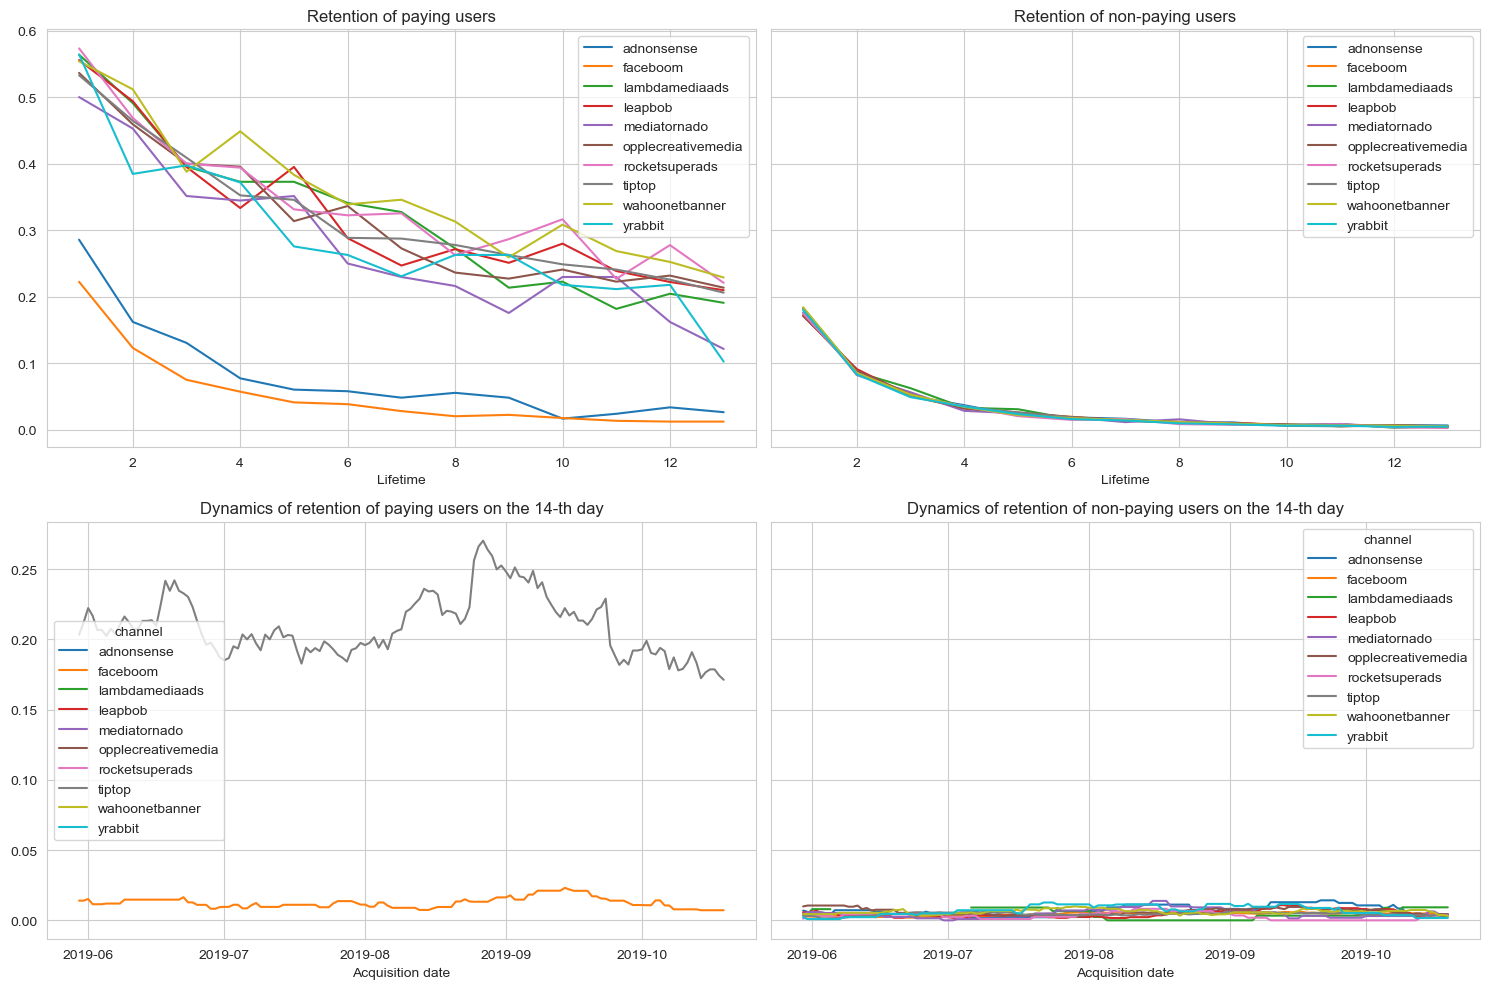

In [37]:
# use plot_retention method to plot retention by various user acquisition sources
plot_retention(retention_channel, retention_history_channel, horizon, window=30) 

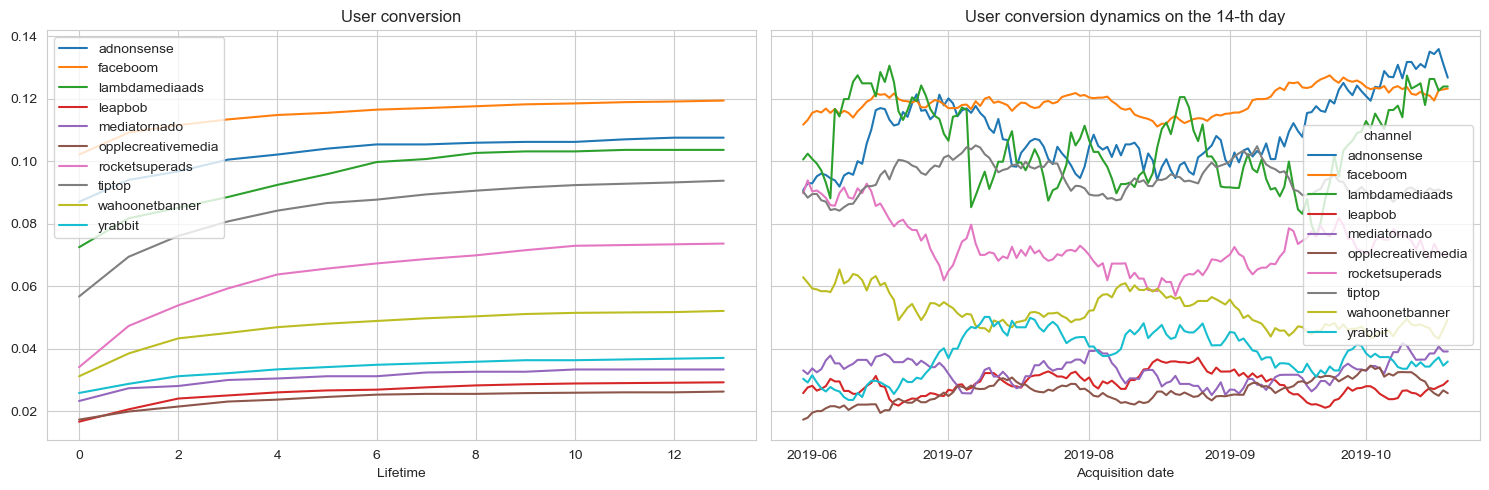

In [38]:
# use plot_conversion method to plot conversion by various user acquisition sources
plot_conversion(conversion_channel, conversion_history_channel, horizon, window=30)

Adnonsense and Faceboom both show the worst numbers in terms of payer users retention and simultaneously leading in the user conversion metric. On the contrary, the most expensive marketing source TipTop shows relatively weak user conversion rate below 10% and relatively strong retention rates, especially the 14-th day retention dynamics.

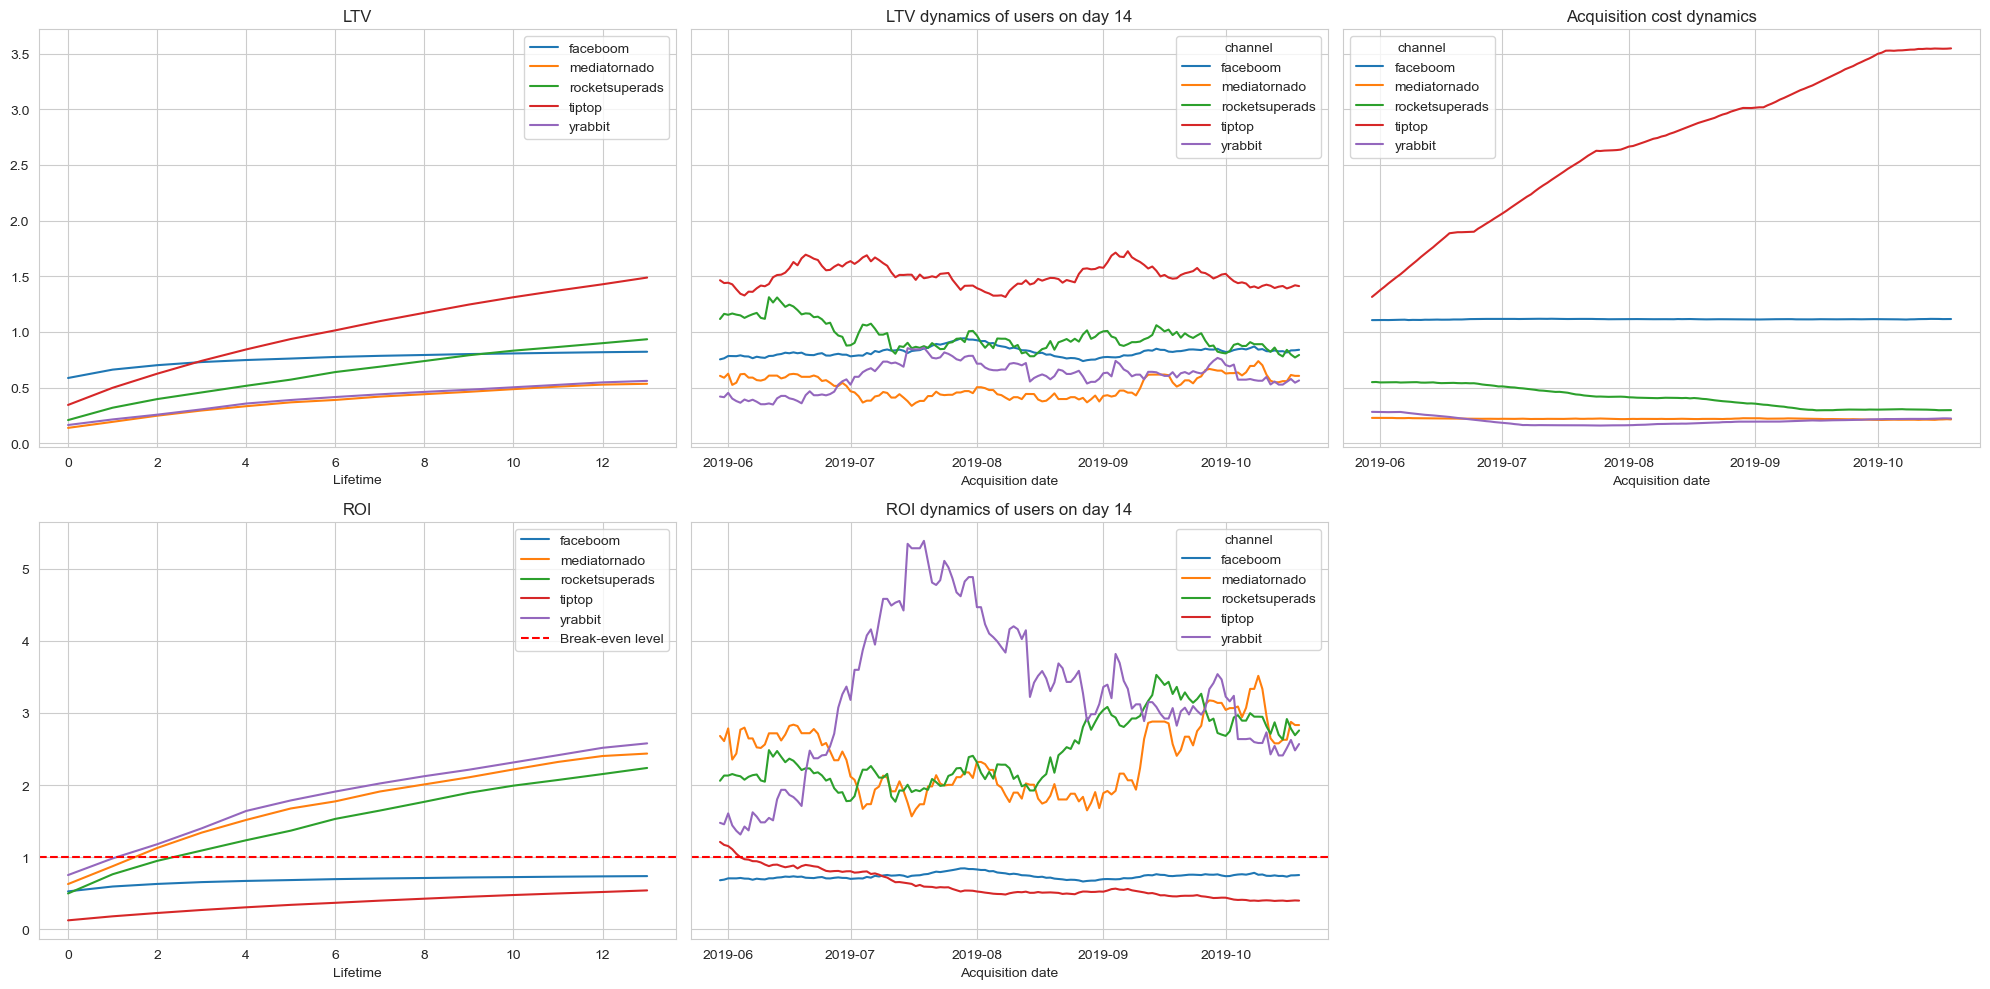

In [39]:
# calculate and plot LTV and ROI for the US users
profiles_filtered_USA = profiles_filtered[profiles_filtered['region'] == 'united states']
profiles_filtered_others = profiles_filtered[profiles_filtered['region'] != 'united states']

ltv_raw_USA, ltv_USA, ltv_history_USA, roi_USA, roi_history_USA = get_ltv(
    profiles_filtered_USA, orders, observation_date, horizon, dimensions=['channel']
)
plot_ltv_roi(ltv_USA, ltv_history_USA, roi_USA, roi_history_USA, horizon, window=30)

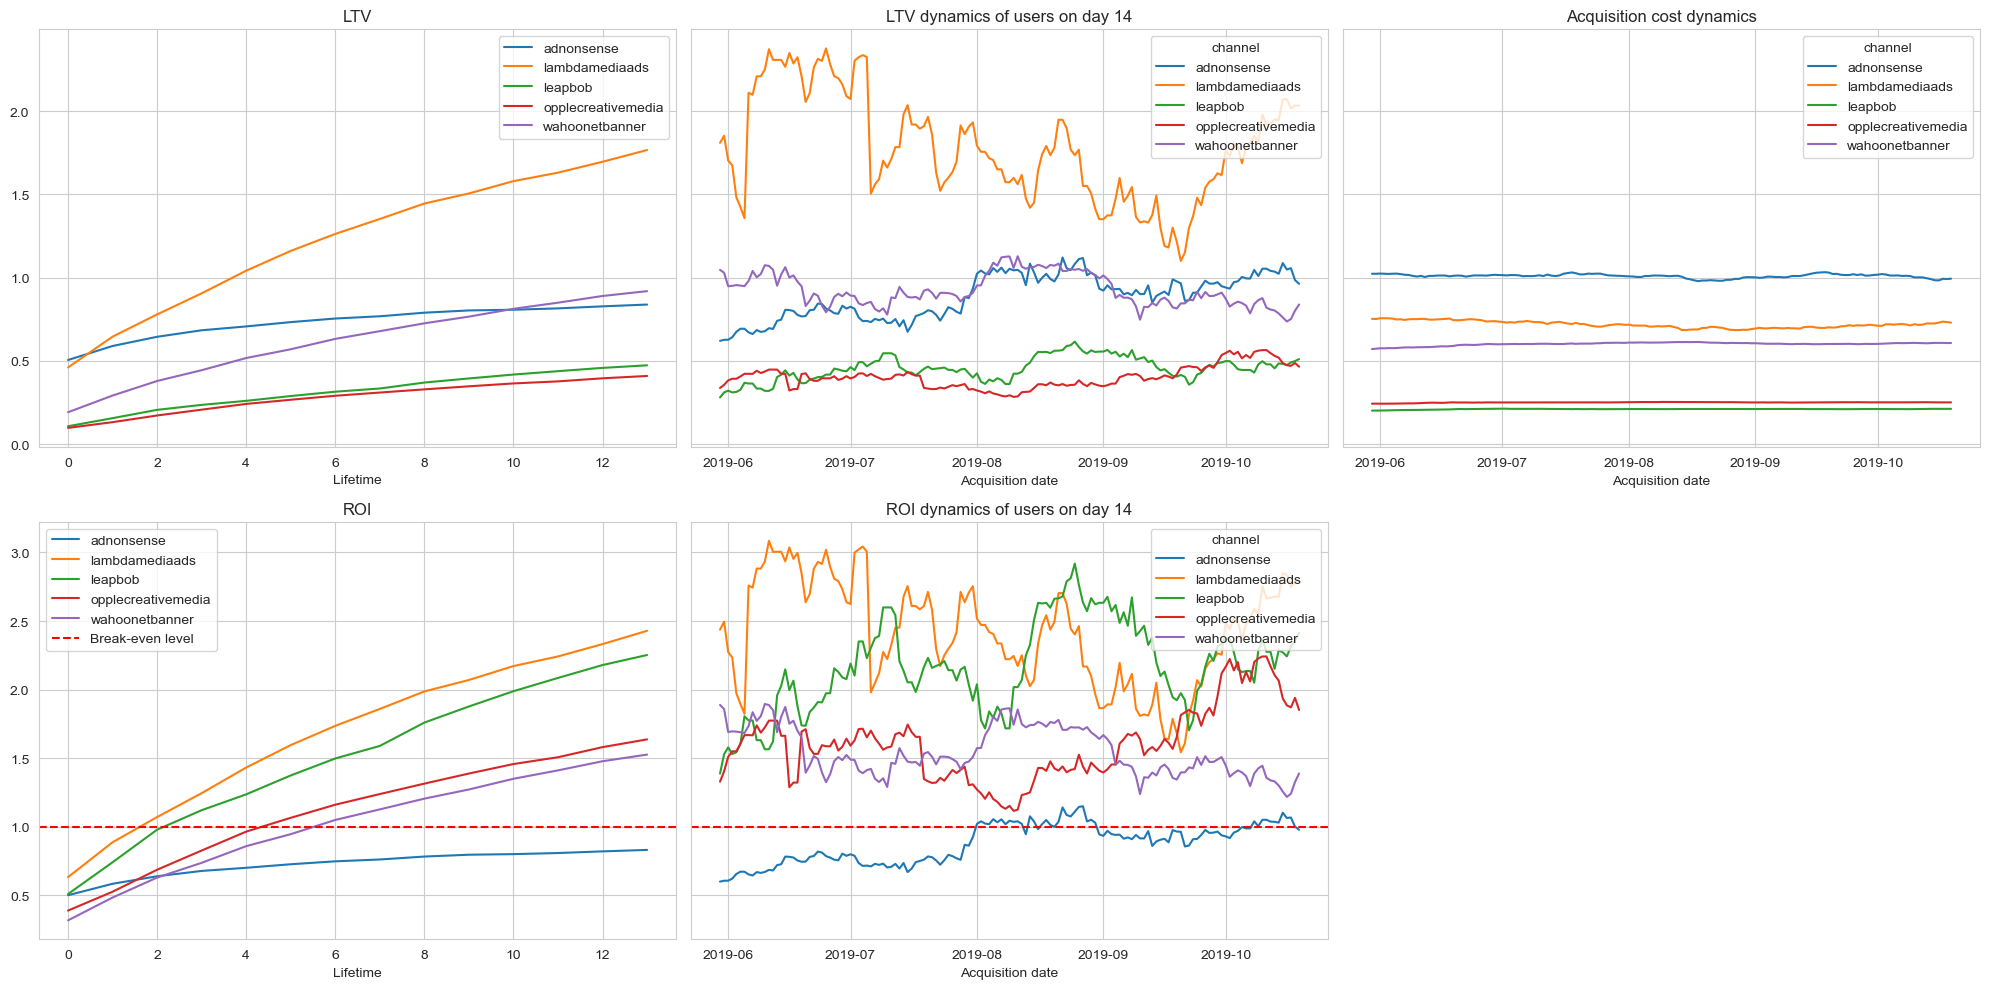

In [40]:
# calculate and plot LTV and ROI for the US users
ltv_raw_others, ltv_others, ltv_history_others, roi_others, roi_history_others = get_ltv(
    profiles_filtered_others, orders, observation_date, horizon, dimensions=['channel']
)
plot_ltv_roi(ltv_others, ltv_history_others, roi_others, roi_history_others, horizon, window=30)

TipTop and Faceboom sources have been used for users acquirals only in the USA. These two sources negatively influenced financial results for the American cohort of users and both have ROI below payback level. In non-US countries Abnonsense shows negative financial results with CAC exceeding LTV for all lifetimes.

Overall, company's marketing campaign is ineffective. On average the costs of acquiring new users are higher comparing to the revenues they bring. The most problematic are users from the USA, that use iPhones and Macs, acquired by TipTop and Faceboom channels.
Altough this user cohort is the most solvent, the costs of getting new customers are significantly higher of potential benefits.
Deep analysis of users behaviour shows that Faceboom has the worst numbers in terms of payer users retention and simultaneously leading in the user conversion metric. On the contrary, the most expensive marketing source TipTop shows relatively weak user conversion rate below 10% and relatively strong retention rates, especially the 14-th day retention dynamics.
The issue with profitability of TipTop and Faceboom rises due to the fact that such volumes of user retention and conversion do not pay off high expenses accrued using these marketing sources with TipTop's customer acquisition costs being on average 3 times larger comparing to the competitors.
The main recommendation would be to reconsider the usage of TipTop and Faceboom as users acquisition sources.

### Step 6. General conclusion

To sum up, over 66% of users acquired between 2019-05-01 and 2019-10-27 come from the United States. The USA leads in both cohorts of clients that made their first purchase and those who didn't. The fraction of payers among total number of clients varies by countries from 3.8% to 6.9% with France showing the smallest percentage.
Despite the fact that, the US users brought the largest revenues for the company with LTV above 0.6, American cohort is the only one unprofitable with ROI below 1. The US 30 day moving average CAC rises sharply in June-July 2019, whereas for users from other countries marketing costs remain stable.
iPhone device accounts for over a third of all users activity. Moreover, customers with Apple devices, such as iPhones and Macs have the highest conversion rate as well - 6.21% and 6.36% respectively.
Most of the users were obtained without marketing campaigns. Such 'organic' users account for 37.62% of all unique user sessions. However, this user cohort monetizes poorly and makes up only about 2% of 'organic' payers.

The most expensive acquisition channels are Tiptop and Faceboom. The channels account for around 52% and 31% of total marketing costs of the observed period respectively. Although it should be highlighted that Tiptop, being the most expensive marketing source, does not show best customer attraction results and provides only 9.6% of payer audience conversion. Whereas significantly cheaper marketing sources Adnonsense and Lambdamediaads that consumed in total 5.19% of overall marketing finances brought more qualitative users with conversion rates 11.34% and 10.47% respectively.
TipTop also shows the highest customer acquisition cost (CAC) with the median of 3 units per user as well as 1-st and 3-d quantiles between roughly 2.5 and 3.5 units per user. These figures are twice higher comparing to the second expensive acquisition source - Faceboom with the median of 1.11 units and upper interquartile range border around 1.15 units. Furthermore, TipTop's CAC dynamics increases vastly during the analysing period and by October 2019 becomes even 3.5 time larger comparing to other sources.
TipTop and Faceboom marketing channels have ROI below payback level and are ineffective.

Retention plots show regular customers behaviour with significant drop in retention levels for non-payer users as well as stable decline of retention with time. The retention dynamics on the 14-th lifetime day is mostly stable among all monthly cohorts.
On the contrary, conversion rate's 14-th day dynamics represents that users acquired in June 2019 convert into buyers in higher volumes comparing to other user monthly cohorts (conversion rate peaks in the interval between 0.065 and 0.07, an all time high values).

PC platform shows lowest lifetime value of its users, although the costs of acquiring PC customers is the smallest as well, thus making PC cohort the most profitable and reaching PC payback level on the 7-th day of the lifetime. Moreover, PC is the only cohort that never falls below the payback level on the 14-th day lifetime no matter when the users are acquired.
Apart from PC, ROI payback level reaches Android cohort, though with much more modest ROI results (break even for Android users is reached around 11-th day of the lifetime). 
ROI of Mac and iPhone cohorts doesn't reach break even point for the whole 14 day lifetime period.

Overall, company's marketing campaign is ineffective. On average the costs of acquiring new users are higher comparing to the revenues they bring. The most problematic are users from the USA, that use iPhones and Macs, acquired by TipTop and Faceboom channels.
Altough this user cohort is the most solvent, the costs of getting new customers are significantly higher of potential benefits.
Deep analysis of users behaviour shows that Faceboom has the worst numbers in terms of payer users retention and simultaneously leading in the user conversion metric. On the contrary, the most expensive marketing source TipTop shows relatively weak user conversion rate below 10% and relatively strong retention rates, especially the 14-th day retention dynamics.
The issue with profitability of TipTop and Faceboom rises due to the fact that such volumes of user retention and conversion do not pay off high expenses accrued using these marketing sources with TipTop's customer acquisition costs being on average 3 times larger comparing to the competitors.
The main recommendation would be to reconsider the usage of TipTop and Faceboom as users acquisition sources.